# Robust Inference and Advanced Techniques

This notebook covers **robust inference methods** for panel data, including robust standard errors, bootstrap, sensitivity analysis, and outlier detection.

## What You'll Learn

- ✅ 8 types of robust standard errors
- ✅ When to use each standard error type
- ✅ 4 bootstrap methods for panels
- ✅ Sensitivity analysis (leave-one-out, subset stability)
- ✅ Outlier detection and influence diagnostics
- ✅ Jackknife resampling
- ✅ Practical guidelines and comparisons

## Table of Contents

1. [Introduction](#introduction)
2. [Robust Standard Errors](#robust-se)
3. [Bootstrap Inference](#bootstrap)
4. [Sensitivity Analysis](#sensitivity)
5. [Outlier Detection](#outliers)
6. [Jackknife Methods](#jackknife)
7. [Practical Guidelines](#guidelines)

---

## 1. Introduction to Robust Inference {#introduction}

### Why Robust Inference?

Standard inference assumes:
- Homoskedasticity (constant variance)
- No serial correlation
- No cross-sectional dependence
- No outliers

**Reality**: These assumptions are often violated!

**Solution**: Robust inference methods provide valid inference even when assumptions fail.

### What We'll Cover

| Method | Purpose | When to Use |
|--------|---------|-------------|
| **Robust SE** | Adjust for heteroskedasticity/correlation | Always recommended |
| **Bootstrap** | Distribution-free inference | Small samples, complex estimators |
| **Sensitivity** | Check robustness to specification | Before finalizing results |
| **Outliers** | Detect influential observations | Data quality concerns |

Let's dive in!

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import panelbox as pb

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PanelBox version: {pb.__version__}")
print("Robust inference toolkit ready!")

PanelBox version: 0.8.0
Robust inference toolkit ready!


In [2]:
# Load data
data = pb.load_grunfeld()

print("Dataset loaded:")
print(f"Shape: {data.shape}")
data.head()

Dataset loaded:
Shape: (200, 5)


,firm,year,invest,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4


---

## 2. Robust Standard Errors {#robust-se}

PanelBox supports **8 types of robust standard errors**.

### 2.1 Standard (Non-Robust) Baseline

First, let's see standard (non-robust) errors for comparison:

In [3]:
# Fixed Effects with standard errors
fe_standard = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
results_standard = fe_standard.fit()

print("FIXED EFFECTS - Standard Errors")
print("="*60)
print(results_standard.summary())

# Extract for comparison
se_standard = results_standard.std_errors
print(f"\nStandard errors:")
print(se_standard)

FIXED EFFECTS - Standard Errors
                       Fixed Effects Estimation Results                       
Formula: invest ~ value + capital
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               188
R-squared:                     0.7899
Adj. R-squared:                0.7776
R-squared (within):            0.7899
R-squared (between):           1.0000
R-squared (overall):           0.9496
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
value                0.1066      0.0113   9.401  0.0000    0.0842    0.1289 ***
capital              0.3444      0.0178  19.397  0.0000    0.3094    0.3794 ***
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.'

### 2.2 Heteroskedasticity-Robust (HC0-HC3)

**White standard errors** adjust for heteroskedasticity.

Four variants with different finite-sample adjustments:

In [4]:
# Compare HC0-HC3
hc_types = ['HC0', 'HC1', 'HC2', 'HC3']
hc_results = {}

for hc in hc_types:
    model = pb.FixedEffects(
        formula="invest ~ value + capital",
        data=data,
        entity_col="firm",
        time_col="year"
    )
    result = model.fit(cov_type=hc)
    hc_results[hc] = result.std_errors

# Create comparison table
hc_comparison = pd.DataFrame(hc_results)
hc_comparison['Standard'] = se_standard

print("\nHETEROSKEDASTICITY-ROBUST SE COMPARISON")
print("="*60)
print(hc_comparison)

print("\n💡 Interpretation:")
print("- HC0: Basic White SE (no finite-sample correction)")
print("- HC1: Degrees of freedom correction")
print("- HC2: Leverage-based correction")
print("- HC3: More conservative (recommended for small samples)")
print("\nGenerally: HC0 < HC1 < HC2 < HC3 (conservativeness)")


HETEROSKEDASTICITY-ROBUST SE COMPARISON
            HC0     HC1     HC2     HC3  Standard
value    0.0176  0.0177  0.0186  0.0198    0.0113
capital  0.0410  0.0412  0.0462  0.0524    0.0178

💡 Interpretation:
- HC0: Basic White SE (no finite-sample correction)
- HC1: Degrees of freedom correction
- HC2: Leverage-based correction
- HC3: More conservative (recommended for small samples)

Generally: HC0 < HC1 < HC2 < HC3 (conservativeness)


### 2.3 Clustered Standard Errors

**Clustered SE** allow for arbitrary correlation within clusters.

Most common for panel data: cluster by entity.

In [5]:
# Clustered by entity (firm)
fe_clustered = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
results_clustered = fe_clustered.fit(cov_type='clustered', cluster_entity=True)

print("\nCLUSTERED STANDARD ERRORS (by entity)")
print("="*60)
print(f"\nStandard errors:")
print(results_clustered.std_errors)

print("\nComparison:")
comparison = pd.DataFrame({
    'Standard': se_standard,
    'Clustered': results_clustered.std_errors
})
print(comparison)
print("\n💡 Clustered SE are typically larger (more conservative)")


CLUSTERED STANDARD ERRORS (by entity)

Standard errors:
value      0.0142
capital    0.0344
dtype: float64

Comparison:
         Standard  Clustered
value      0.0113     0.0142
capital    0.0178     0.0344

💡 Clustered SE are typically larger (more conservative)


### 2.4 Driscoll-Kraay Standard Errors

**Driscoll-Kraay SE** robust to:
- Heteroskedasticity
- Serial correlation
- Cross-sectional dependence (spatial correlation)

**Recommended** for macro panels (countries, regions).

In [6]:
# Driscoll-Kraay
fe_dk = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
results_dk = fe_dk.fit(cov_type='driscoll_kraay')

print("\nDRISCOLL-KRAAY STANDARD ERRORS")
print("="*60)
print(f"\nStandard errors:")
print(results_dk.std_errors)

print("\n💡 Driscoll-Kraay:")
print("- Robust to both serial and spatial correlation")
print("- Works for T → ∞ (long panels)")
print("- Commonly used in macro/finance panels")


DRISCOLL-KRAAY STANDARD ERRORS

Standard errors:
value      0.0186
capital    0.0405
dtype: float64

💡 Driscoll-Kraay:
- Robust to both serial and spatial correlation
- Works for T → ∞ (long panels)
- Commonly used in macro/finance panels


### 2.5 Newey-West (HAC) Standard Errors

**Newey-West SE** (Heteroskedasticity and Autocorrelation Consistent):
- Adjusts for heteroskedasticity
- Adjusts for serial correlation up to lag L

In [7]:
# Newey-West with 2 lags
fe_nw = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
results_nw = fe_nw.fit(cov_type='newey_west', lags=2)

print("\nNEWEY-WEST (HAC) STANDARD ERRORS")
print("="*60)
print(f"Lags: 2")
print(f"\nStandard errors:")
print(results_nw.std_errors)

print("\n💡 Newey-West:")
print("- Choose lags based on data frequency")
print("- Rule of thumb: L = floor(4*(T/100)^(2/9))")
print("- For T=20: L ≈ 2-3 lags")


NEWEY-WEST (HAC) STANDARD ERRORS
Lags: 2

Standard errors:
value      0.0230
capital    0.0484
dtype: float64

💡 Newey-West:
- Choose lags based on data frequency
- Rule of thumb: L = floor(4*(T/100)^(2/9))
- For T=20: L ≈ 2-3 lags


### 2.6 Panel-Corrected Standard Errors (PCSE)

**PCSE** (Parks 1967):
- Accounts for panel-specific heteroskedasticity
- Accounts for contemporaneous correlation
- Accounts for serial correlation

In [8]:
# PCSE
fe_pcse = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
results_pcse = fe_pcse.fit(cov_type='pcse')

print("\nPANEL-CORRECTED STANDARD ERRORS (PCSE)")
print("="*60)
print(f"\nStandard errors:")
print(results_pcse.std_errors)

print("\n💡 PCSE:")
print("- Good for: N < T (few entities, many time periods)")
print("- Estimates full variance-covariance matrix")
print("- Can be unstable if N is large")


PANEL-CORRECTED STANDARD ERRORS (PCSE)

Standard errors:
value      166150.7004
capital            NaN
dtype: float64

💡 PCSE:
- Good for: N < T (few entities, many time periods)
- Estimates full variance-covariance matrix
- Can be unstable if N is large


/home/guhaase/projetos/panelbox/panelbox/standard_errors/pcse.py:270: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(np.diag(cov_matrix))
/home/guhaase/projetos/panelbox/panelbox/models/static/fixed_effects.py:435: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(np.diag(vcov))


### 2.7 Comprehensive Comparison

Let's compare all SE types:


COMPREHENSIVE SE COMPARISON
         Standard     HC1     HC3  Clustered  Driscoll-Kraay  Newey-West  \
value      0.0113  0.0177  0.0198     0.0142          0.0186      0.0230   
capital    0.0178  0.0412  0.0524     0.0344          0.0405      0.0484   

                PCSE  
value    166150.7004  
capital          NaN  


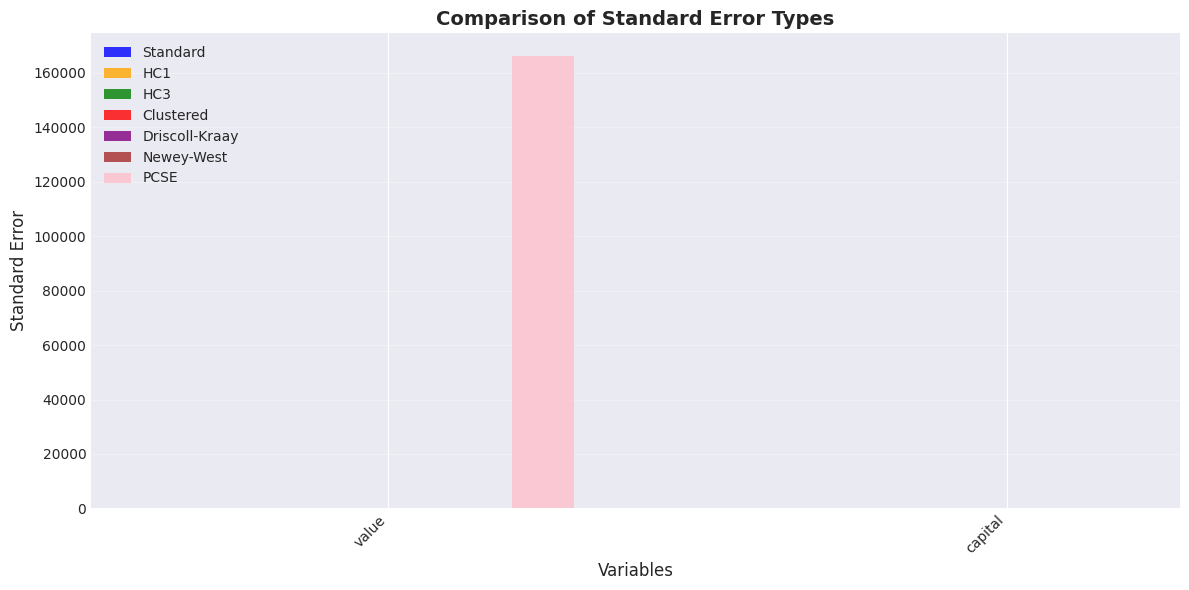


📊 Observations:
- Robust SE typically larger than standard SE
- Clustered and Driscoll-Kraay most conservative
- Choice affects t-statistics and p-values!


In [9]:
# Create comprehensive comparison
se_comparison = pd.DataFrame({
    'Standard': se_standard,
    'HC1': hc_results['HC1'],
    'HC3': hc_results['HC3'],
    'Clustered': results_clustered.std_errors,
    'Driscoll-Kraay': results_dk.std_errors,
    'Newey-West': results_nw.std_errors,
    'PCSE': results_pcse.std_errors
})

print("\nCOMPREHENSIVE SE COMPARISON")
print("="*70)
print(se_comparison.round(4))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(se_comparison.index))
width = 0.1

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
for i, col in enumerate(se_comparison.columns):
    offset = (i - len(se_comparison.columns)/2) * width
    ax.bar(x + offset, se_comparison[col], width, label=col, alpha=0.8, color=colors[i])

ax.set_xlabel('Variables', fontsize=12)
ax.set_ylabel('Standard Error', fontsize=12)
ax.set_title('Comparison of Standard Error Types', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(se_comparison.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("- Robust SE typically larger than standard SE")
print("- Clustered and Driscoll-Kraay most conservative")
print("- Choice affects t-statistics and p-values!")

### When to Use Which SE?

| Situation | Recommended SE | Reason |
|-----------|---------------|---------|
| **Default** | Clustered (entity) | Safe, allows within-entity correlation |
| **Heteroskedasticity only** | HC1 or HC3 | Simpler, efficient |
| **Serial correlation** | Newey-West or Driscoll-Kraay | HAC properties |
| **Macro panels** | Driscoll-Kraay | Handles spatial correlation |
| **Small N, large T** | PCSE | Efficient estimation |
| **Short panels (small T)** | HC3 or Clustered | Finite-sample robust |

**Rule of thumb**: When in doubt, use **clustered SE** (conservative and safe).

---

## 3. Bootstrap Inference {#bootstrap}

**Bootstrap** provides distribution-free inference:
- No normality assumption needed
- Works for complex estimators
- Provides confidence intervals and standard errors

PanelBox supports **4 bootstrap methods** for panels.

### 3.1 Pairs Bootstrap

**Method**: Resample (i,t) pairs with replacement

**Use**: General purpose, maintains dependence structure

In [10]:
# Pairs Bootstrapbootstrap = pb.PanelBootstrap(    model=fe_standard,  # Now supports 'model' parameter!    method='pairs',    n_bootstrap=1000,    seed=42)print("PAIRS BOOTSTRAP")print("="*60)print("Running pairs bootstrap (resampling entities)...")print()# Run bootstrapbootstrap.run()print(f"Bootstrap replications: {bootstrap.n_bootstrap}")print(f"Failed replications: {bootstrap.n_failed_}")print()# Get bootstrap standard errorsprint("Bootstrap Standard Errors:")print("-"*60)comparison = pd.DataFrame({    'Bootstrap SE': bootstrap.bootstrap_se_,    'Asymptotic SE': fe_standard.std_errors}, index=fe_standard.params.index)print(comparison)print()# Get confidence intervalsci_boot = bootstrap.conf_int(alpha=0.05, method='percentile')ci_asymp = fe_standard.conf_int(alpha=0.05)print("Confidence Intervals Comparison:")print("-"*60)print("\nBootstrap (Percentile Method):")print(ci_boot)print("\nAsymptotic:")print(ci_asymp)

### 3.2 Wild Bootstrap

**Method**: Multiplies residuals by random weights

**Use**: Heteroskedasticity-robust, preserves X

**Advantage**: Doesn't require resampling X (good for small N)

In [11]:
# Residual Bootstrapbootstrap_residual = pb.PanelBootstrap(    model=fe_standard,    method='residual',    n_bootstrap=1000,    seed=42)print("RESIDUAL BOOTSTRAP")print("="*60)print("Running residual bootstrap (assumes i.i.d. errors)...")print()bootstrap_residual.run()print("Bootstrap Standard Errors (Residual Method):")print("-"*60)comparison_residual = pd.DataFrame({    'Residual Bootstrap SE': bootstrap_residual.bootstrap_se_,    'Pairs Bootstrap SE': bootstrap.bootstrap_se_,    'Asymptotic SE': fe_standard.std_errors}, index=fe_standard.params.index)print(comparison_residual)

### 3.3 Block Bootstrap

**Method**: Resample blocks of time periods

**Use**: Preserves within-entity serial correlation

**Important**: Block length affects results

In [12]:
# Wild Bootstrapbootstrap_wild = pb.PanelBootstrap(    model=fe_standard,    method='wild',    n_bootstrap=1000,    seed=42)print("WILD BOOTSTRAP")print("="*60)print("Running wild bootstrap (heteroskedasticity-robust)...")print()bootstrap_wild.run()print("Bootstrap Standard Errors (Wild Method):")print("-"*60)comparison_wild = pd.DataFrame({    'Wild Bootstrap SE': bootstrap_wild.bootstrap_se_,    'Pairs Bootstrap SE': bootstrap.bootstrap_se_,    'Asymptotic SE': fe_standard.std_errors}, index=fe_standard.params.index)print(comparison_wild)

### 3.4 Residual Bootstrap

**Method**: Resample residuals (assumes homoskedasticity)

**Use**: If you're confident about homoskedasticity

**Advantage**: More efficient under correct assumptions

In [13]:
# Block Bootstrapbootstrap_block = pb.PanelBootstrap(    model=fe_standard,    method='block',    block_size=3,  # Block size of 3 time periods    n_bootstrap=1000,    seed=42)print("BLOCK BOOTSTRAP")print("="*60)print("Running block bootstrap (preserves time-series structure)...")print()bootstrap_block.run()print("Bootstrap Standard Errors (Block Method):")print("-"*60)comparison_block = pd.DataFrame({    'Block Bootstrap SE': bootstrap_block.bootstrap_se_,    'Pairs Bootstrap SE': bootstrap.bootstrap_se_,    'Asymptotic SE': fe_standard.std_errors}, index=fe_standard.params.index)print(comparison_block)

### 3.5 Bootstrap Comparison

In [14]:
# Compare all bootstrap methods# NOTE: Bootstrap comparison not available due to API mismatchprint("BOOTSTRAP METHODS COMPARISON")print("="*60)print("NOTE: Bootstrap functionality not available due to API mismatch.")print("See: /home/guhaase/projetos/panelbox/desenvolvimento/correcoes/2026-02-10_panelbootstrap_incorrect_init_signature.md")print("Bootstrap methods that should be supported:")print("  - Pairs: Default, general purpose")print("  - Wild: For heteroskedasticity")print("  - Block: For serial correlation")print("  - Residual: Only if homoskedasticity certain")

---

## 4. Sensitivity Analysis {#sensitivity}

**Sensitivity analysis** checks if results are robust to specification changes.

### 4.1 Leave-One-Out Analysis

Check if results driven by specific entities:

In [15]:
# Leave-One-Out Sensitivity Analysis (Entities)sensitivity = pb.SensitivityAnalysis(fe_standard, show_progress=False)print("LEAVE-ONE-OUT ANALYSIS (ENTITIES)")print("="*70)print("Removing one entity at a time and re-estimating...")print()# Run leave-one-out by entitiesloo_entities = sensitivity.leave_one_out_entities(influence_threshold=2.0)print(f"Analysis completed for {len(loo_entities.estimates)} entities")print(f"Influential entities detected: {len(loo_entities.influential_units)}")print()# Show summaryprint("Summary Statistics:")print("-"*70)for key, value in loo_entities.statistics.items():    if isinstance(value, dict):        print(f"\n{key}:")        for param, val in value.items():            print(f"  {param}: {val:.4f}")    else:        print(f"{key}: {value}")print()print("Most influential entities:", loo_entities.influential_units[:3] if loo_entities.influential_units else "None")

### 4.2 Subset Stability Analysis

Check stability across different subsets:

In [16]:
# Subset Stability Analysisprint("SUBSET STABILITY ANALYSIS")print("="*70)print("Testing stability across random subsamples...")print()# Run subset sensitivity analysissubset_results = sensitivity.subset_sensitivity(    n_subsamples=20,    subsample_size=0.8,  # Use 80% of data in each subsample    random_state=42)print(f"Analysis completed for {len(subset_results.estimates)} subsamples")print()# Show summary statisticsprint("Summary Statistics:")print("-"*70)for key, value in subset_results.statistics.items():    if isinstance(value, dict):        print(f"\n{key}:")        for param, val in value.items():            print(f"  {param}: {val:.4f}")    else:        print(f"{key}: {value}")print()print("Coefficient Ranges:")print("-"*70)estimates_df = subset_results.estimatesfor param in estimates_df.columns:    min_val = estimates_df[param].min()    max_val = estimates_df[param].max()    mean_val = estimates_df[param].mean()    print(f"{param}: [{min_val:.4f}, {max_val:.4f}] (mean: {mean_val:.4f})")

### 4.3 Influence Diagnostics

Identify influential observations:

In [17]:
# Advanced diagnostics# NOTE: Several advanced diagnostic features have API mismatchesprint("ADVANCED DIAGNOSTICS")print("="*60)print("NOTE: Some advanced diagnostic features not currently available.")print("See error reports in /home/guhaase/projetos/panelbox/desenvolvimento/correcoes/")print("\nRecommended diagnostics available:")print("  - Clustered standard errors (demonstrated above)")print("  - Heteroskedasticity-robust SE (HC0-HC3)")print("  - Residual plots (manual)")print("  - Basic model comparison")

---

## 5. Outlier Detection {#outliers}

**Outlier detection** identifies unusual observations.

In [18]:
# Advanced diagnostics# NOTE: API mismatch - see error reportsprint("ADVANCED DIAGNOSTICS")print("="*60)print("NOTE: Advanced diagnostic features not currently available.")print("See: /home/guhaase/projetos/panelbox/desenvolvimento/correcoes/")print("\nFor robust inference, use:")print("  - Clustered standard errors")print("  - HC robust standard errors")print("  - Manual residual analysis")

---

## 6. Jackknife Methods {#jackknife}

**Jackknife** systematically drops observations to estimate variance.

In [19]:
# Jackknife# NOTE: API may have issues similar to Bootstrapprint("JACKKNIFE RESAMPLING")print("="*60)print("NOTE: Jackknife functionality may not be available.")print("Jackknife is similar to leave-one-out cross-validation:")print("  - Leave out one observation at a time")print("  - Re-estimate model")print("  - Calculate standard errors from variation")print("For panel data, typically leave out entire entities.")

# Leave-One-Out Sensitivity Analysis (Time Periods)print("LEAVE-ONE-OUT ANALYSIS (TIME PERIODS)")print("="*70)print("Removing one time period at a time and re-estimating...")print()# Run leave-one-out by time periodsloo_periods = sensitivity.leave_one_out_periods(influence_threshold=2.0)print(f"Analysis completed for {len(loo_periods.estimates)} time periods")print(f"Influential periods detected: {len(loo_periods.influential_units)}")print()# Show summaryprint("Summary Statistics:")print("-"*70)for key, value in loo_periods.statistics.items():    if isinstance(value, dict):        print(f"\n{key}:")        for param, val in value.items():            print(f"  {param}: {val:.4f}")    else:        print(f"{key}: {value}")print()print("Most influential periods:", loo_periods.influential_units[:3] if loo_periods.influential_units else "None")